# CAP 394 - Brazilian Cerrado Vegetation Areas Identification Using MODIS MOD13Q1 Data

## 1. Introduction

In this work, the aim is to use MODIS MOD13Q1 data to identify remaining areas of brazilian Cerrado. The data are available through an INPE server, accessed with the _wtss_ package. 6 data types will be used:

+ Digital Number:
    + Blue
    + Red
    + NIR
    + MIR
+ Vegetation Indexes:
    + NDVI
    + EVI
    
The identification of the brazilian Cerrado remaining areas is going to be done using machine learning algorithms, more specifically, a DTW ( _Dynamic Time Warping_ ) and a Random Forest classification using the DTW created data. To use such type of algorithms, a training set have to be used, in this case, a set of training data was acquired by the analyst through visual interpretation.

<img src="./Images/graph.png" width="700">

Below can be found the packages needed in the project.

In [1]:
from IPython.display import HTML, Image
from fastdtw import fastdtw
from functools import partial
from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean
from shapely.geometry import shape, Point
from shapely.geometry.polygon import Polygon
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import cohen_kappa_score as kappa
from time import time
from tqdm import tqdm_notebook as tqdm
from wtss import wtss
import gdal
import geopandas as gp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import shapefile as shp
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

## 2. Study Area

The area chosen for the classification is the municipality of São Desidério, located at the west region of the Bahia state. The region is characterized by large areas of agriculture, being the grains production the main activity. The municipality is entirely inside the Cerrado biome, and more information about it can be found in [here (portuguese)](https://pt.wikipedia.org/wiki/S%C3%A3o_Desid%C3%A9rio).

To obtain the boundaries of the study area, a _shapefile_ file was obtained from Instituto Basileiro de Geografia e Estatística (IBGE) from this [link](ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2015/Brasil/BR/br_municipios.zip) and saved to the computer.

The following code is used to load the _shapefile_ as a dataset in `geopandas`, and the database associated to the geometries can be seen using the `.head()` command.

,NM_MUNICIP,CD_GEOCMU,geometry
0,CAIUÁ,3509106,POLYGON ((-51.86001052999998 -21.5807199056459...
1,CASTILHO,3511003,POLYGON ((-51.41936432700003 -20.6810765586240...
2,DRACENA,3514403,POLYGON ((-51.48515406800003 -21.4276462056422...
3,ESTRELA DO NORTE,3515301,POLYGON ((-51.57097467399996 -22.3988718766653...
4,EUCLIDES DA CUNHA PAULISTA,3515350,POLYGON ((-52.44569233499996 -22.6082794076701...


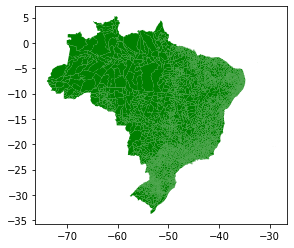

In [2]:
path = "/home/bruno/Documents/BR/BRMUE250GC_SIR.shp"

brasil = gp.read_file(path, encoding="utf-8")

brasil.plot(color='green')
brasil.head()

As we can see, there is an attribute called `NM_MUNICIP`, which contains the name of each brazilian municipality. The São Desidério munipality and its Coordenate Reference System (CRS) are extracted with the following code.

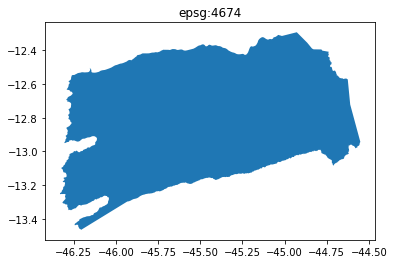

In [3]:
sao_desiderio = brasil[brasil["NM_MUNICIP"]=="SÃO DESIDÉRIO"]

sao_desiderio.plot()
plt.title(str(sao_desiderio.crs['init']))

brasil = None

It can be noticed in the plot's title that the municipality's CRS is `epsg: 4674`. The MODIS data used in this project can be projected in a different CRS, so it should be checked, in case a change in the projection for the municipality is needed. The following code show what is the MODIS data CRS.

In [4]:
w = wtss("http://www.esensing.dpi.inpe.br")

cv_scheme = w.describe_coverage("MOD13Q1")
ts = w.time_series("MOD13Q1", "ndvi", -12.532790, -45.199361, 
                   start_date="2017-01-01", end_date="2018-01-01").timeline

print(cv_scheme['crs']['wkt'])

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]


At the output's end, it can be seen that the MODIS data provided is projected to `EPSG: 4326` CRS, so, a projection step is needed in order to make the data compatible.

The projected boundaries are then stored into a _shapefile_, in order to be used later.

Text(0.5, 1, 'epsg:4326')

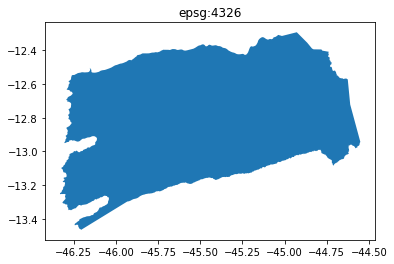

In [5]:
sao_desiderio = sao_desiderio.to_crs({'init': 'epsg:4326'})

sao_desiderio.to_file("./Data/Shape/sao_desiderio_epsg4326.shp",  encoding="utf-8")

sao_desiderio.plot()
plt.title(str(sao_desiderio.crs['init']))

##  3. Data acquisition

Time series data will be used, so, somehow they have to be downloaded. In this project, this data are acquired using a python package called `wtss`. It can be used to access data cubes and its information. A nice description about the package can be found in [here](https://github.com/e-sensing/wtss.py). The python version of this tool was used to access the data, but first the data must be made available by a provider. In the case of this project, data provided by INPE ( _Instituto Nacional de Pesquisas Espaciais_ ) is used, from the MODIS product MOD13Q1.

### 3.1 Time Series of a Point

The `WTSS` functions handle the access of time series based on the coordinate of a point, series (like the MODIS product name), coverage (such as each band or vegetation index of the product), and a start and end date. In order to code the data download of the entire municipality, this process must be repeated many times.

The function below gets the time series of a point according to the previously cited parameters. It also needs a polygon in the `shapely` package format, so the function can check if the point is inside the polygon area, and avoid unnecessary time series retrieval.

The output is `None` if the point is not within the polygon, otherwise it will return an array with the time series values according to the coverage wanted.

In [6]:
# lat: float
# long: float
# series: string
# coverage: string
# date1: string like 2019-10-23
# date2: string like 2019-12-28
# poly: shapely polygon

def retrieveDataFromPoint(lat, long, series, coverage, date1, date2, poly):
    
    pt = Point(long, lat)
    
    if poly.contains(pt):
        result = None
        while result is None:
            try:
                w = wtss("http://www.esensing.dpi.inpe.br")
                ts = w.time_series(series, coverage, lat, long, start_date=date1, end_date=date2)
        
                return ts[coverage]
            except:
                pass
    else:
        return None

Below a line graph shows how a time series obtained with this function can be seen - in this case, an NDVI series.

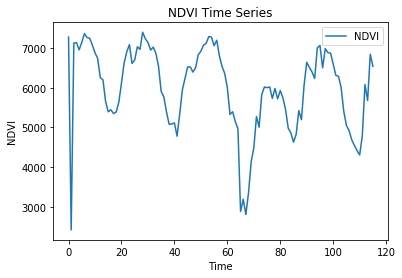

In [7]:
np.warnings.filterwarnings('ignore')

sf = shp.Reader("./Data/Shape/sao_desiderio_epsg4326.shp")
matplotDict = []

for shape in sf.shapeRecords(): # Iterate through shapes in shapefile
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    for i in x:
        matplotDict.append((x[x.index(i)], y[x.index(i)]))  # Convert coordinates to be read by Shapely pkg

    poly = Polygon(matplotDict)
    
cov = retrieveDataFromPoint(-12.532790, -45.199361, "MOD13Q1", "ndvi", 
                            "2013-01-01", "2018-01-01", poly)
plt.plot(cov, label="NDVI")
plt.title("NDVI Time Series")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

### 3.2 All Coverage Time Series in a `numpy` Array

The function above `retrieveDataFromPoint()`  gets the time series for a certain coordinate. This is useful to analyze the profile of a single point, but the aim is to find the areas, so it has to be spatialized. The function below gets one single time series in order to know the size of the array needed (lat, long and total number of dates). With the series dimensions, it creates a matrix to receive all the data downloaded within a polygon, obtained via a _shapefile_ saved to the computer.

The `WTSS` package allows the user to see basic parameters of the dataset. One of this parameters is called "spatial_resolution". This parameter makes the creation of the array possible, providing valuable information for the creation of the array needed to store all the series.

The retrieval is made for a single data type at a time (`blue`, `red`, `nir`, `mir`, `NDVI` and `EVI`), using almost all cores of the computer processor. This data is used in the identification of the brazilian Cerrado remaining areas.

In [8]:
def retrieveDataMatrix(lat1, lat2, long1, long2, t1, t2, series, coverage, poly):
    t = time()
    
    # Shows info
    print("------------------------- RETRIEVING "+coverage.upper()+" DATA --------------------------")

    print("Processing...")
    
    # server data
    w = wtss("http://www.esensing.dpi.inpe.br")

    # gets coverage info
    cv_scheme = w.describe_coverage(series)

    # range i (height) and j (width) based on the spatial resolution
    r_i = int((lat2-lat1)/cv_scheme["spatial_resolution"]["y"])+1
    r_j = int((long2-long1)/cv_scheme["spatial_resolution"]["x"])+1

    # print info about the n° of lines and columns
    y = (lat1+(lat2-lat1)/2)
    x = (long1+(long2-long1)/2)
    
    w = wtss("http://www.esensing.dpi.inpe.br")
    ts = w.time_series(series, coverage, lat1, long1, start_date=t1, end_date=t2)
    time_series =  ts.timeline
    data = ts[coverage]
    
    coord = []

    # loop that get all things done (get data of a point for a certain , retrieves mean value of data,
    for i in range(r_i):
        for j in range(r_j):
            y = lat1+i*cv_scheme["spatial_resolution"]["y"]
            x = long1+j*cv_scheme["spatial_resolution"]["x"]

            coord.append([y, x])
    
    with mp.Pool(processes=mp.cpu_count()) as pool:
        data = pool.starmap(partial(retrieveDataFromPoint), [(lat, long, series, coverage, t1, t2, poly) for (lat,long) in coord])
    
    # creates the variable to receive the data
    all_data = np.zeros((r_i, r_j, len(time_series)))
    
    for i in range(r_i):
        for j in range(r_j):
            if data[i*r_j+j]==None:
                all_data[i,j,:] = None
            else:
                for k in range(all_data.shape[2]):
                    all_data[i,j,k] = data[i*r_j+j][k]
    
    # saves the data
    np.save("/home/bruno/Documents/Data Science/dates.npy", time_series)
    np.save("/home/bruno/Documents/Data Science/"+coverage+".npy", all_data)
    
    print("Data shape:", all_data.shape)
    print("Data size: %.3f MB" % (os.path.getsize("/home/bruno/Documents/Data Science/"+coverage+".npy")*1e-6))
    
    print("Total time: %.3f minutes\n" % ((time()-t)/60))
    
    return r_i, r_j

As elucidated in the introduction, the bands used are `blue`, `red`, `nir`, `mir` and the vegetation indexes `ndvi` and `evi`. The following code handles the acquisition of this 6 different coverages time series, and if the point in the array does not lies within the polygon specified, the series is filled with `None`.

In [9]:
lat1 = float(sao_desiderio.bounds['miny'])
lat2 = float(sao_desiderio.bounds['maxy'])
long1 = float(sao_desiderio.bounds['minx'])
long2 = float(sao_desiderio.bounds['maxx'])

# abre o shapefile
sf = shp.Reader("./Data/Shape/sao_desiderio_epsg4326.shp")
matplotDict = []

for shape in sf.shapeRecords(): # Iterate through shapes in shapefile
    x = [i[0] for i in shape.shape.points[:]]  # Initially for use in matplotlib to check shapefile
    y = [i[1] for i in shape.shape.points[:]]  # Initially for use in matplotlib to check shapefile
    for i in x:
        matplotDict.append((x[x.index(i)], y[x.index(i)]))  # Convert coordinates to be read by Shapely pkg

    poly = Polygon(matplotDict)  # main

coverages = ["red", "blue", "mir", "nir", "ndvi", "evi"]

for cov in coverages:
    [r_i, r_j] = retrieveDataMatrix(lat1=lat1, lat2=lat2, 
                                     long1=long1, long2=long2, 
                                     t1="2013-01-01", t2="2018-01-01", 
                                     series="MOD13Q1", 
                                     coverage=cov, 
                                     poly=poly)

------------------------- RETRIEVING RED DATA --------------------------
Processing...
Data shape: (562, 854, 116)
Data size: 445.392 MB
Total time: 14.585 minutes

------------------------- RETRIEVING BLUE DATA --------------------------
Processing...
Data shape: (562, 854, 116)
Data size: 445.392 MB
Total time: 14.303 minutes

------------------------- RETRIEVING MIR DATA --------------------------
Processing...
Data shape: (562, 854, 116)
Data size: 445.392 MB
Total time: 11.271 minutes

------------------------- RETRIEVING NIR DATA --------------------------
Processing...
Data shape: (562, 854, 116)
Data size: 445.392 MB
Total time: 10.995 minutes

------------------------- RETRIEVING NDVI DATA --------------------------
Processing...
Data shape: (562, 854, 116)
Data size: 445.392 MB
Total time: 11.836 minutes

------------------------- RETRIEVING EVI DATA --------------------------
Processing...
Data shape: (562, 854, 116)
Data size: 445.392 MB
Total time: 12.417 minutes



During the retrieval, the data is stored in the computer's memory using the format `.npy`. To access it, the following code is needed, where the files are opened as `numpy` arrays. Afeter opening the arrays, an animation for the time series is also shown, corresponding to a the `ndvi` time series for the study area.

In [10]:
#####
# Loading data
blue = np.load("/home/bruno/Documents/Data Science/blue.npy")
red =  np.load("/home/bruno/Documents/Data Science/red.npy")
nir =  np.load("/home/bruno/Documents/Data Science/nir.npy")
mir =  np.load("/home/bruno/Documents/Data Science/mir.npy")
ndvi = np.load("/home/bruno/Documents/Data Science/ndvi.npy")
evi =  np.load("/home/bruno/Documents/Data Science/evi.npy")
ts =   np.load("/home/bruno/Documents/Data Science/dates.npy", allow_pickle=True)

print("Blue Shape:", blue.shape)
print("Red Shape:", red.shape)
print("Nir Shape:", nir.shape)
print("Mir Shape:", mir.shape)
print("NDVI Shape:", ndvi.shape)
print("EVI Shape:", evi.shape)
print("Time Series Shape:", ts.shape)

#####
# Showing animation
fig, ax = plt.subplots(figsize=(14, 8))

ax.set_xlim((0, ndvi.shape[1]))
ax.set_ylim((0, ndvi.shape[0]))

im = ax.imshow(ndvi[:,:,0])
print("\nAnimation for the raw data")

def init():
    im.set_data(ndvi[:,:,0])
    return (im,)

def animate(i):
    data_slice = ndvi[:,:,i]
    ax.set_title(str(ts[i]), fontweight="bold")
    im.set_data(data_slice)
    return (im,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=ndvi.shape[2], interval=400, blit=True)

anim.save("./Images/time_series1.gif", writer='imagemagick', fps=int(ndvi.shape[2]/6))
plt.close()

Image(url="./Images/time_series1.gif")

Blue Shape: (562, 854, 116)
Red Shape: (562, 854, 116)
Nir Shape: (562, 854, 116)
Mir Shape: (562, 854, 116)
NDVI Shape: (562, 854, 116)
EVI Shape: (562, 854, 116)
Time Series Shape: (116,)

Animation for the raw data


The study area is a relatively large municipality, so it corresponds to a large number of series that were acquired by this script. To count the number of series retrieved, the following code was used, showing that a total number of **1.145.946** series were downloaded.

In [11]:
count = np.sum(np.isnan(blue[:,:,0])*-1+1)
            
print("Total amount of time series:", count*6)

Total amount of time series: 1145946


### 3.3 Outliers & Filtering

The data used in the project is not perfectly clean, although it is a product created by the combination of the best pixels from a 16 days time interval. Many things can cause deviations on satellite data obtained with optical sensors, the biggest problem being the cloud and cloud shadows coverage in a scene. This two features have extreme different spectral behavior - the cloud being responsible for a saturation area in the picture, and the could shadow being responsible for a black area, with low signal.

This type of coverage (clouds and clouds shadows) is not wanted in the project, due to the fact that it hides the information of the ground reflectance under it. In this case, some algorithms can be used to minimize the effects of the cloud influence in the time series.

In this project, clouds and cloud's shadows are considered outliers, and therefore must be removed or diminished. The method chosen to do so is the algorithm described by Hamunyela _et al._ (2013), in their [article](https://www.mdpi.com/2072-4292/5/12/6159). The function used to filter the outliers can be found below.

In [12]:
# ts: array of the time series values

def remove_outliers(ts):
    ts_corrected = ts.copy()
    per = 10/100

    for j in range(1, len(ts_corrected) - 1):
        if (ts[j]-ts[j-1]<-per*ts[j-1]) and (ts[j]-ts[j+1]<-per*ts[j+1]):
            ts_corrected[j] = (ts[j-1]+ts[j+1])/2

    return ts_corrected

An example of this algorithm's application can be seen below. Around the beginning of 2017, which is a common time for high incidence of clouds, there is unarguably an outlier like the ones mentioned before. The filtering method was able to detect it and suppress its influence.

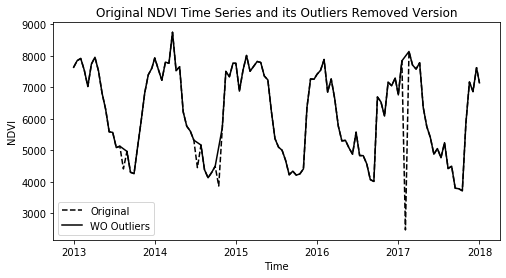

In [13]:
a = remove_outliers(ndvi[500,700,:])

plt.figure(figsize=(8,4))
plt.plot(ts,ndvi[500,700,:], "k--", label="Original")
plt.plot(ts,a, "k", label="WO Outliers")
plt.title("Original NDVI Time Series and its Outliers Removed Version")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

Removed the outliers, the series need to be filtered in order to have a smother shape, what can improve the accuracy of the classification algorithms. The method chosen to filter the time series is the Savitzky-Golay filter, and was adapted from the implementation found in [here (SciPy Cookbook)](https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html).

In [14]:
# ts: array of the time series values

def filter_savitzky_golay(ts):
    from math import factorial
    window_size = 5
    order = 3
    deriv = 0
    rate = 1

    y = np.asarray(ts)

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        print("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    # precompute coefficients
    b = np.mat([[k ** i for i in order_range] for k in range(-half_window, half_window + 1)])
    m = np.linalg.pinv(b).A[deriv] * rate ** deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs(y[1:half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

An example of this algorithm's application can be seen below:

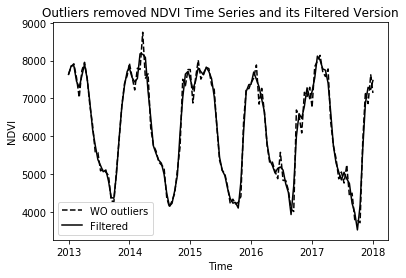

In [15]:
b = filter_savitzky_golay(a)

plt.plot(ts,a, "k--", label="WO outliers")
plt.plot(ts,b, "k", label="Filtered")
plt.title("Outliers removed NDVI Time Series and its Filtered Version")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

With both functions defined (`outliers_removal()` and `filter_savitzky_golay()`), the 6 datasets can be filtered to be used in the DTW classification.

In [16]:
size = red.shape

for i in tqdm(range(size[0])):
    for j in range(size[1]):        
        blue[i,j,:] = filter_savitzky_golay(remove_outliers(blue[i,j,:]))
        red[i,j,:] = filter_savitzky_golay(remove_outliers(red[i,j,:]))
        nir[i,j,:] = filter_savitzky_golay(remove_outliers(nir[i,j,:]))
        mir[i,j,:] = filter_savitzky_golay(remove_outliers(mir[i,j,:]))
        ndvi[i,j,:] = filter_savitzky_golay(remove_outliers(ndvi[i,j,:]))
        evi[i,j,:] = filter_savitzky_golay(remove_outliers(evi[i,j,:]))
        
        
# Showing animation
fig, ax = plt.subplots(figsize=(14, 8))

ax.set_xlim((0, ndvi.shape[1]))
ax.set_ylim((0, ndvi.shape[0]))

im = ax.imshow(ndvi[:,:,0])
print("Animation for the data without outliers and filtered.")

def init():
    im.set_data(ndvi[:,:,0])
    return (im,)

def animate(i):
    data_slice = ndvi[:,:,i]
    ax.set_title(str(ts[i]), fontweight="bold")
    im.set_data(data_slice)
    return (im,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=ndvi.shape[2], interval=400, blit=True)
plt.close()

anim.save("./Images/time_series1.gif", writer='imagemagick', fps=int(ndvi.shape[2]/6))
plt.close()

Image(url="./Images/time_series1.gif")


Animation for the data without outliers and filtered.


## 4. DTW Classification

The classification to be used in this project is based on a Dynamic Time Warping (DTW) product over the series. The DTW is a method to measure the similarity between two time series. A figure of how the association between each vertex of two time series is made can be seen below, in comparison to a simple euclidean method. (Source: [Csillik et al., 2019](https://www.mdpi.com/2072-4292/11/10/1257/htm))

<img src="./Images/dtw_eucli.webp">

This method is largely used in video, audio, and graphics data, for example, but in remote sensing, it can be used to measure the similarity between the reflectance time series of a certain pixel to a reference time series of a land cover/land use classified pixel. The following graph shows the differences between two series of different land use/cover.

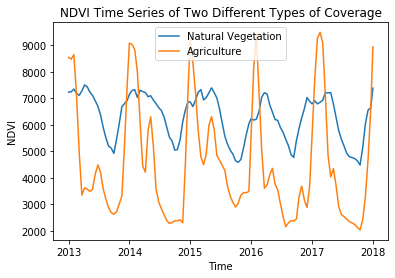

In [17]:
plt.plot(ts, ndvi[451,718], label="Natural Vegetation")
plt.plot(ts, ndvi[100,100], label="Agriculture")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.title("NDVI Time Series of Two Different Types of Coverage")
plt.show()

### 4.1 Reference

Since different types of land cover/land use present variant spectral behavior along the time, a classification can be made using the DTW distance as a similarity factor. The method, as simple as this explanation goes, would be used to perform a pixel-based classification, ignoring the spatial relation between them, considering only the spectral response during the observation time for the pixel. To create the reference, samples should be acquired from the data to each class, and from them a reference time series can be fabricated.

To this project, the samples were acquired only for the "not deforested" area, and everything not classified as so, was classified as "deforested area". The following code gets the indexes of the reference series for the "not deforested areas", previously stored into a _.txt_ file.

In [18]:
arq_ref = open("./Data/Reference/reference_indices_DTW.txt", "r")
arq_ref.readline()

lines = arq_ref.readlines()
a = []

for line in lines:
    a += line.strip().split("\t")
    
reference = np.zeros([int(len(a)/2), 2], dtype=int)

b = 0
for i in range(0, int(len(a)), 2):
    reference[b,0] = int(a[i])
    reference[b,1] = int(a[i+1])
    b += 1
    
print(reference.shape)

(100, 2)


The 100 samples were collected randomly, located in spread locations in the study area, like the following plot shows.

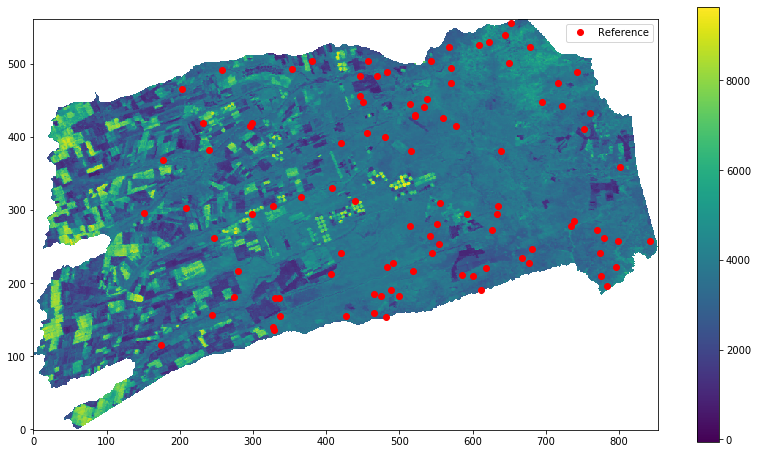

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))
im = plt.imshow(evi[:,:,7], origin="lower")
fig.colorbar(im)
plt.plot(reference[:,0], reference[:,1], "ro", label="Reference")
plt.legend()

After retrieving the indexes of the reference for the classification, the series for each index is separated to be used later in the processes of reference series definition.

In [20]:
all_ref_blue = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_red = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_nir = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_mir = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_ndvi = np.zeros([reference.shape[0], ts.shape[0]])
all_ref_evi = np.zeros([reference.shape[0], ts.shape[0]])

for i in range(reference.shape[0]):
    all_ref_blue[i, :] = blue[reference[i,1], reference[i,0], :]
    all_ref_red[i, :] = red[reference[i,1], reference[i,0], :]
    all_ref_nir[i, :] = nir[reference[i,1], reference[i,0], :]
    all_ref_mir[i, :] = mir[reference[i,1], reference[i,0], :]
    all_ref_ndvi[i, :] = ndvi[reference[i,1], reference[i,0], :]
    all_ref_evi[i, :] = evi[reference[i,1], reference[i,0], :]

With all the reference series properly separated, a main series that represents the temporal spectral behavior for each one of the datasets could be built (`blue`, `red`, `nir`, `mir`, `ndvi` and `evi`). For example, to establish the reference series for the blue data, the median blue value of each timestamp group of values obtained from all input reference series was calculated, then this value was used as the final reference. By doing so, outliers that could not be purged by the previously methods did not greatly interfere during the building of the main reference.

In [21]:
ref_blue = np.zeros(ts.shape)
ref_red = np.zeros(ts.shape)
ref_nir = np.zeros(ts.shape)
ref_mir = np.zeros(ts.shape)
ref_ndvi = np.zeros(ts.shape)
ref_evi = np.zeros(ts.shape)

for i in range(0, ref_blue.shape[0], 1):
    ref_blue[i] = np.median(all_ref_blue[:,i])
    ref_red[i] = np.median(all_ref_red[:,i])
    ref_nir[i] = np.median(all_ref_nir[:,i])
    ref_mir[i] = np.median(all_ref_mir[:,i])
    ref_ndvi[i] = np.median(all_ref_ndvi[:,i])
    ref_evi[i] = np.median(all_ref_evi[:,i])

For a better visualization of the data, the following plot shows all the different references built (one for each dataset) and also each reference built in comparison to its origin data.

Text(0, 0.5, 'EVI')

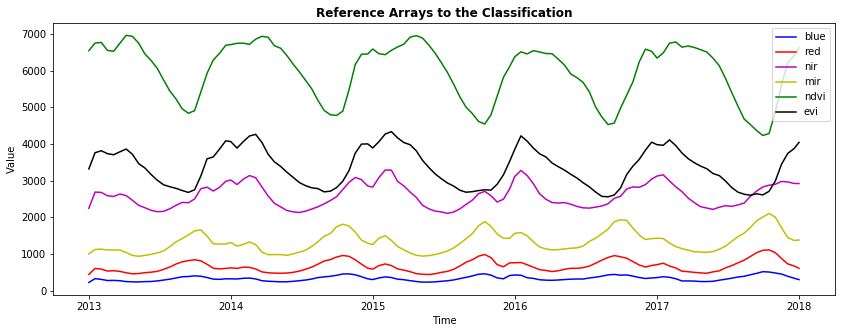

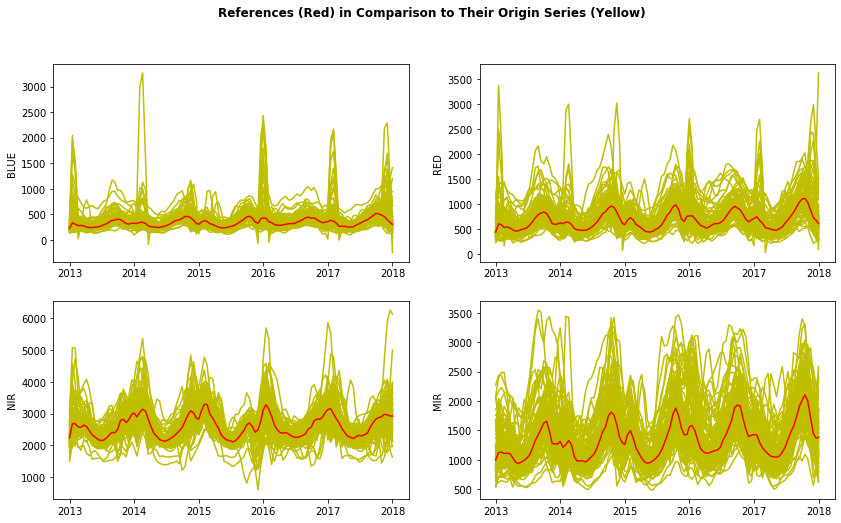

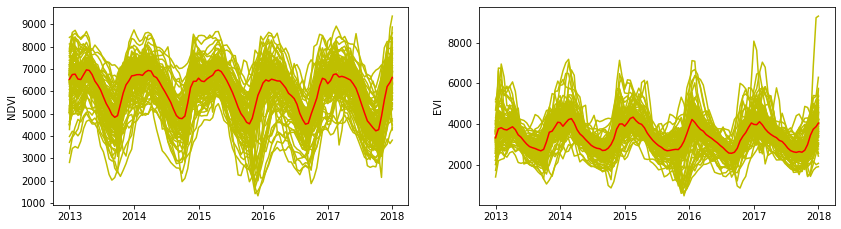

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(ts, ref_blue, "b", label="blue")
plt.plot(ts, ref_red, "r", label="red")
plt.plot(ts, ref_nir, "m", label="nir")
plt.plot(ts, ref_mir, "y", label="mir")
plt.plot(ts, ref_ndvi, "g", label="ndvi")
plt.plot(ts, ref_evi, "k", label="evi")
plt.legend()
plt.ylabel("Value")
plt.xlabel("Time")
plt.title("Reference Arrays to the Classification", fontweight="bold")

plt.figure(figsize=(14, 8))
plt.suptitle("References (Red) in Comparison to Their Origin Series (Yellow)", fontweight="bold")
plt.subplot(221)
for i in range(all_ref_blue.shape[0]):
    plt.plot(ts, all_ref_blue[i, :], "y")
plt.plot(ts, ref_blue, "r")
plt.ylabel("BLUE")

plt.subplot(222)
for i in range(all_ref_red.shape[0]):
    plt.plot(ts, all_ref_red[i, :], "y")
plt.plot(ts, ref_red, "r")
plt.ylabel("RED")

plt.subplot(223)
for i in range(all_ref_nir.shape[0]):
    plt.plot(ts, all_ref_nir[i, :], "y")
plt.plot(ts, ref_nir, "r")
plt.ylabel("NIR")

plt.subplot(224)
for i in range(all_ref_mir.shape[0]):
    plt.plot(ts, all_ref_mir[i, :], "y")
plt.plot(ts, ref_mir, "r")
plt.ylabel("MIR")

plt.figure(figsize=(14, 8))

plt.subplot(221)
for i in range(all_ref_ndvi.shape[0]):
    plt.plot(ts, all_ref_ndvi[i, :], "y")
plt.plot(ts, ref_ndvi, "r")
plt.ylabel("NDVI")

plt.subplot(222)
for i in range(all_ref_evi.shape[0]):
    plt.plot(ts, all_ref_evi[i, :], "y")
plt.plot(ts, ref_evi, "r")
plt.ylabel("EVI")

### 4.2 Using the DTW Algorithm

The DTW algorithm can be easily used if the `fastdtw` package is imported, but this function has two different outputs: the distance between the series, and the match made among the nodes of the series. In order to use parallel processing tools, a function was created that returns only the needed information: the distance between the series, as can be seen below.

In [23]:
def dtw_fun(arr, ref):
    if not np.isnan(arr).any():
        return fastdtw(arr, ref, dist=euclidean)[0]
    else:
        return None

After the DTW function is defined, it could be used to calculate all the distances between each reference index and its respective final reference, as shown in the code below.

In [24]:
list_indices = []

for i in range(all_ref_blue.shape[0]):
    list_indices.append(i)

th_blue = None
th_red = None
th_nir = None
th_mir = None
th_ndvi = None
th_evi = None
        
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_blue = pool.starmap(partial(dtw_fun), [(all_ref_blue[i,:], ref_blue) for i in list_indices])

with mp.Pool(processes=mp.cpu_count()) as pool:
    th_red = pool.starmap(partial(dtw_fun), [(all_ref_red[i,:], ref_red) for i in list_indices])
    
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_nir = pool.starmap(partial(dtw_fun), [(all_ref_nir[i,:], ref_nir) for i in list_indices])
    
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_mir = pool.starmap(partial(dtw_fun), [(all_ref_mir[i,:], ref_mir) for i in list_indices])
    
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_ndvi = pool.starmap(partial(dtw_fun), [(all_ref_ndvi[i,:], ref_ndvi) for i in list_indices])
    
with mp.Pool(processes=mp.cpu_count()) as pool:
    th_evi = pool.starmap(partial(dtw_fun), [(all_ref_evi[i,:], ref_evi) for i in list_indices])

To have an idea of the data behavior, the DTW distances calculated in the previous cell could be shown in a group of boxplots below. Considering that all the reference points belong to the same class (forest), it can be expected that other group of series that belong to the same class should present a similar behavior. The values for the DTW distance of deforested areas should be greater than the values presented here.

Text(0.5, 1.0, 'Reference Samples DTW Distances Calculated\nto the Final (Median) Reference')

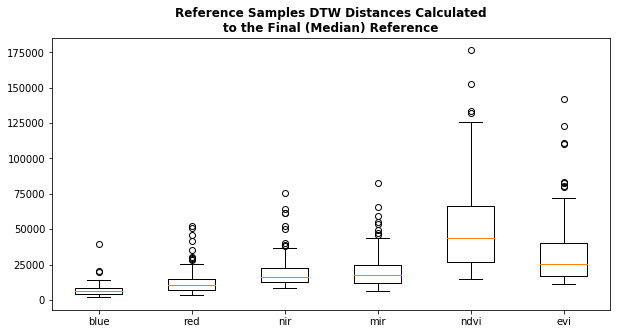

In [25]:
plt.figure(figsize=(10, 5))
plt.boxplot([th_blue, th_red, th_nir, th_mir, th_ndvi, th_evi])
plt.xticks([1, 2, 3, 4, 5, 6], ['blue', 'red', 'nir', 'mir', 'ndvi', 'evi'])
plt.title("Reference Samples DTW Distances Calculated\nto the Final (Median) Reference", fontweight="bold")

The DTW distance is then calculated for each time series that that could be acquired and saved for the interest region. The arrays `blue`, `red`, `nir`, `mir`, `ndvi` and `evi` store all the 1.145.946 time series downloaded.

Because of the data size, a multiprocessing approach should be enough to decrease the processing time needed. The DTW distance to each stored time series should then be calculated, according to its respectively reference time series to the "forest" class.

This code results in 6 different arrays the size of the fist two dimensions of the time series stack - it is equivalent of a "map of distances" to the study area. The code below handles the calculations of the DTW distances to each one of the 1.145.946 time series, and the total time shown below represents the amount of time needed to run the code in an 8 cores machine.

In [27]:
tt = time()

size = blue.shape

list_indices = []

for i in range(size[0]):
    for j in range(size[1]):
        list_indices.append([i,j])

result_blue = None
result_red = None
result_nir = None
result_mir = None
result_ndvi = None
result_evi = None

t = time()
print("Processing DTW BLUE...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_blue = pool.starmap(partial(dtw_fun), [(blue[i,j,:], ref_blue) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW RED...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_red = pool.starmap(partial(dtw_fun), [(red[i,j,:], ref_red) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW NIR...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_nir = pool.starmap(partial(dtw_fun), [(nir[i,j,:], ref_nir) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW MIR...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_mir = pool.starmap(partial(dtw_fun), [(mir[i,j,:], ref_mir) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW NDVI...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_ndvi = pool.starmap(partial(dtw_fun), [(ndvi[i,j,:], ref_ndvi) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

t = time()
print("Processing DTW EVI...")
with mp.Pool(processes=mp.cpu_count()) as pool:
    result_evi = pool.starmap(partial(dtw_fun), [(evi[i,j,:], ref_evi) for (i,j) in list_indices])
print("Time: %.3f minutes" % ((time()-t)/60))

dist_blue = np.zeros((size[0], size[1]), dtype=float)
dist_red  = np.zeros((size[0], size[1]), dtype=float)
dist_nir  = np.zeros((size[0], size[1]), dtype=float)
dist_mir  = np.zeros((size[0], size[1]), dtype=float)
dist_ndvi = np.zeros((size[0], size[1]), dtype=float)
dist_evi  = np.zeros((size[0], size[1]), dtype=float)

for i in range(0, size[0]):
    dist_blue[i,:] = result_blue[i*size[1]:i*size[1]+size[1]]
    dist_red[i,:] = result_red[i*size[1]:i*size[1]+size[1]]
    dist_nir[i,:] = result_nir[i*size[1]:i*size[1]+size[1]]
    dist_mir[i,:] = result_mir[i*size[1]:i*size[1]+size[1]]
    dist_ndvi[i,:] = result_ndvi[i*size[1]:i*size[1]+size[1]]
    dist_evi[i,:] = result_evi[i*size[1]:i*size[1]+size[1]]

print("Total Time: %.3f minutes" % ((time()-tt)/60))

np.save("./Data/Time_Series/dist_blue.npy", dist_blue)
np.save("./Data/Time_Series/dist_red.npy", dist_red)
np.save("./Data/Time_Series/dist_nir.npy", dist_nir)
np.save("./Data/Time_Series/dist_mir.npy", dist_mir)
np.save("./Data/Time_Series/dist_ndvi.npy", dist_ndvi)
np.save("./Data/Time_Series/dist_evi.npy", dist_evi)

Processing DTW BLUE...
Time: 84.549 minutes
Processing DTW RED...
Time: 85.097 minutes
Processing DTW NIR...
Time: 85.232 minutes
Processing DTW MIR...
Time: 86.425 minutes
Processing DTW NDVI...
Time: 85.062 minutes
Processing DTW EVI...
Time: 84.262 minutes
Total Time: 510.650 minutes


After the DTW distance-maps calculation was completed, this maps could be plotted, as well as the histogram for the distances, so that they could be better understood.

In [28]:
dist_blue = np.load("./Data/Time_Series/dist_blue.npy")
dist_red  = np.load("./Data/Time_Series/dist_red.npy")
dist_nir  = np.load("./Data/Time_Series/dist_nir.npy")
dist_mir  = np.load("./Data/Time_Series/dist_mir.npy")
dist_ndvi = np.load("./Data/Time_Series/dist_ndvi.npy")
dist_evi  = np.load("./Data/Time_Series/dist_evi.npy")

ts  = np.load("./Data/Time_Series/dates.npy", allow_pickle=True)

Text(0, 0.5, '')

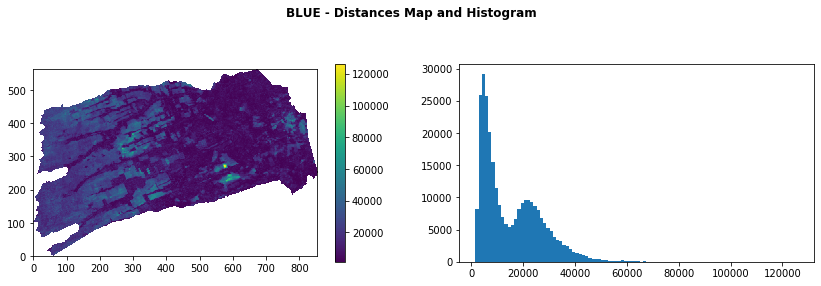

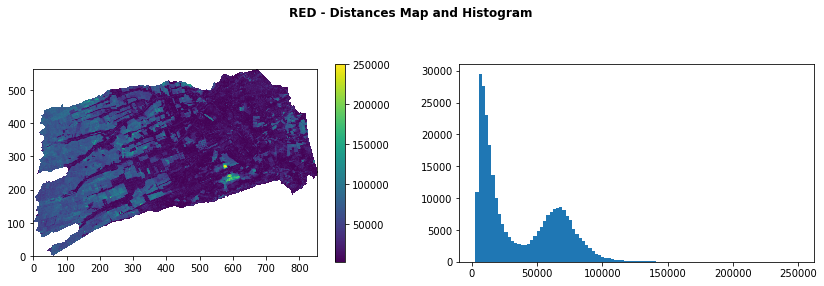

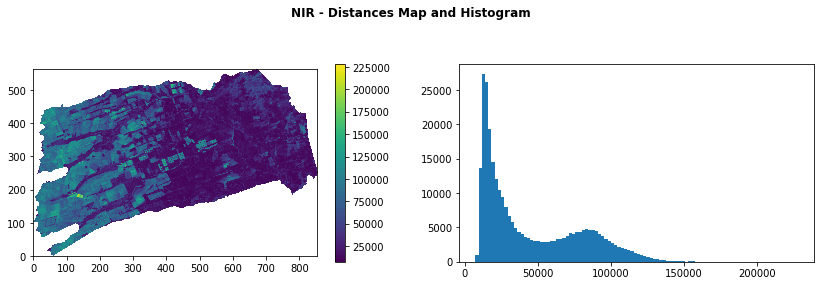

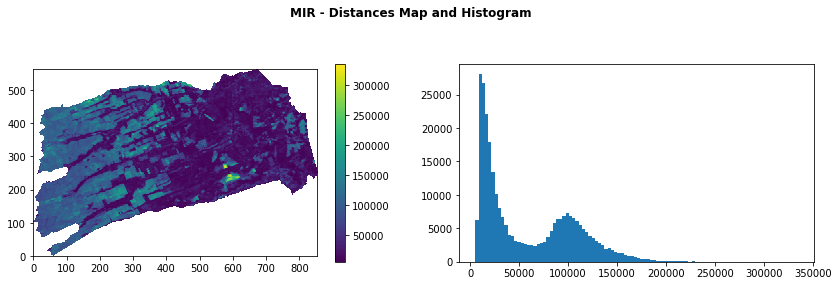

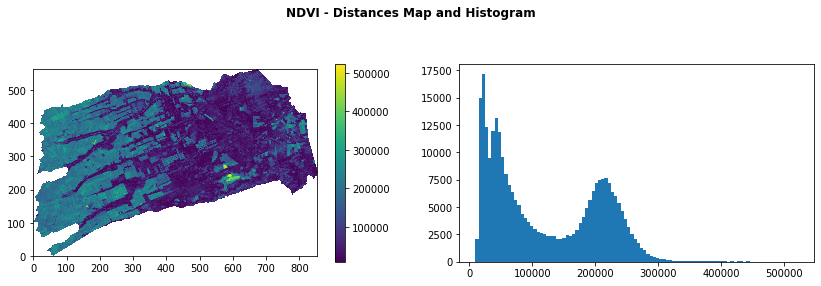

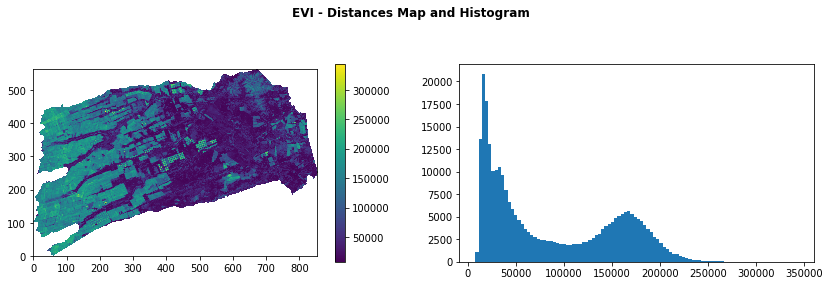

In [29]:
np.warnings.filterwarnings('ignore')

#
plt.figure(figsize=(14, 8))
plt.suptitle("BLUE - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_blue, origin="lower")
plt.colorbar()

plt.subplot(222)
plt.hist(dist_blue.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("RED - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_red, origin="lower")
plt.colorbar()

plt.subplot(222)
plt.hist(dist_red.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("NIR - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_nir, origin="lower")
plt.colorbar()

plt.subplot(222)
plt.hist(dist_nir.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("MIR - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_mir, origin="lower")
plt.colorbar()

plt.subplot(222)
plt.hist(dist_mir.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("NDVI - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_ndvi, origin="lower")
plt.colorbar()

plt.subplot(222)
plt.hist(dist_ndvi.ravel(), bins=100)
plt.ylabel("")

#
plt.figure(figsize=(14, 8))
plt.suptitle("EVI - Distances Map and Histogram", fontweight="bold")

plt.subplot(221)
plt.imshow(dist_evi, origin="lower")
plt.colorbar()

plt.subplot(222)
plt.hist(dist_evi.ravel(), bins=100)
plt.ylabel("")

The distance-maps show that, the higher the difference between the reference time series for the "forest" class is, greater is the DTW distance. Great DTW distances are shown in the maps as lighter colors, so, a visual analysis shows already where the forest areas are located.

All the histograms plotted show the same type of curve. This curve is composed by the global maximum peak point, followed by a valley, and then a second local peak point. The first peak point represents the median DTW distances from all the "forest" time series to the reference series. The second peak represents the median of the other classes DTW distances to the "forest" reference.

In this scenario, it can be supposed that each type of DTW distance follows its own distribution. In this case, the types could be described as:

+ Forest series compared to forest reference; and 
+ Other classes series compared to the forest reference.

With that in mind, the classification was made using a _random forest_ algorithm, using the calculated distance maps as input bands. The following topic exemplifies better the execution of this method.

## 4. Classification

For the classification, a Random Forest algorithm contained in the is used. This method was implemented in the `sklearn` package, and more about it can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

The first step to apply this classification method is to normalize the data. The following code shows how it was done, by a simple method.

In [30]:
# Blue
min_n = np.nanmin(dist_blue.ravel())
max_n = np.nanmax(dist_blue.ravel())

dist_blue_n = (dist_blue-min_n)/(max_n-min_n)

# Red
min_n = np.nanmin(dist_red.ravel())
max_n = np.nanmax(dist_red.ravel())

dist_red_n = (dist_red-min_n)/(max_n-min_n)

# NIR
min_n = np.nanmin(dist_nir.ravel())
max_n = np.nanmax(dist_nir.ravel())

dist_nir_n = (dist_nir-min_n)/(max_n-min_n)

# MIR
min_n = np.nanmin(dist_mir.ravel())
max_n = np.nanmax(dist_mir.ravel())

dist_mir_n = (dist_mir-min_n)/(max_n-min_n)

# NDVI
min_n = np.nanmin(dist_ndvi.ravel())
max_n = np.nanmax(dist_ndvi.ravel())

dist_ndvi_n = (dist_ndvi-min_n)/(max_n-min_n)

# EVI
min_n = np.nanmin(dist_evi.ravel())
max_n = np.nanmax(dist_evi.ravel())

dist_evi_n = (dist_evi-min_n)/(max_n-min_n)

In the case of the random forest, the classification must have references for both classes: Forest and Not-Forest. For each class, a total of 200 samples were colected by the analyst, by visual inspection in higher resolution images.

The code below get the indexes of the references.

In [31]:
arq_ref = open("./Data/Reference/reference_indices_RF_Forest.txt", "r")
arq_ref.readline()

lines = arq_ref.readlines()
a = []

for line in lines:
    a += line.strip().split("\t")
    
r_Forest = np.zeros([int(len(a)/2), 2], dtype=int)

b = 0
for i in range(0, int(len(a)), 2):
    r_Forest[b,0] = int(a[i])
    r_Forest[b,1] = int(a[i+1])
    b += 1
    
print("Shape of Forest Reference:", r_Forest.shape)

arq_ref = open("./Data/Reference/reference_indices_RF_Not_Forest.txt", "r")
arq_ref.readline()

lines = arq_ref.readlines()
a = []

for line in lines:
    a += line.strip().split("\t")
    
r_NotForest = np.zeros([int(len(a)/2), 2], dtype=int)

b = 0
for i in range(0, int(len(a)), 2):
    r_NotForest[b,0] = int(a[i])
    r_NotForest[b,1] = int(a[i+1])
    b += 1
    
print("Shape of Not Forest Reference:", r_Forest.shape)

Shape of Forest Reference: (200, 2)
Shape of Not Forest Reference: (200, 2)


After the indexes' reading, a zeros array is created with the same shape of the distance maps. Here, the pixels relative to the Forest reference are changed to 1, and the Not-Forest pixels are changed to 2.

In [32]:
ref = np.zeros(dist_blue_n.shape)

for (i,j) in r_Forest:
    ref[j,i] = 1
    
for (i,j) in r_NotForest:
    ref[j,i] = 2
    
for i in range(ref.shape[0]):
    for j in range(ref.shape[1]):
        if np.isnan(dist_blue_n[i,j]):
            ref[i,j] = None

In order to feed the Random Forest model with the training samples selected from the distance maps, a stack should be created to organize the data. The code below shows how it was done.

In [33]:
stack = np.zeros([dist_blue_n.shape[0], dist_blue_n.shape[1], 6])

stack[:,:,0] = dist_blue_n
stack[:,:,1] = dist_red_n
stack[:,:,2] = dist_nir_n
stack[:,:,3] = dist_mir_n
stack[:,:,4] = dist_ndvi_n
stack[:,:,5] = dist_evi_n

Then, the training samples should be collected from the stack created in the code above. This information id what is going to be used to train the random forest model.

In [34]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (ref > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# classification labels
labels = np.unique(ref[ref > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster
X = stack[ref > 0, :]
y = ref[ref > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 400 samples
The training data include 2 classes: [1. 2.]
Our X matrix is sized: (400, 6)
Our y array is sized: (400,)


With the training samples prepared, the model is ready to be trained.

Before training, some parameters that define the approach taken with the classification algorithm must be defined. In the case of Random Forest, the number of trees should be defined, to then apply it.

The implementation made in `sklearn` has an optional output parameter called `oob_score`, which means 'Out of Bag Score'. This score was used to judge what would be a better number of trees in the algorithm, like the graph below shows.

Text(0, 0.5, 'Out of Bag Score (%)')

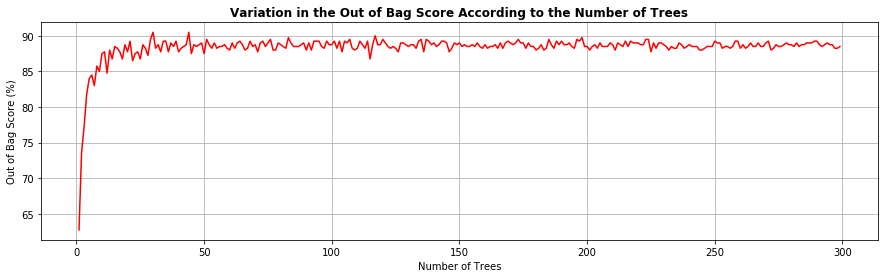

In [35]:
xx = []
yy = []

for i in range(1,300,1):
    # Initialize our model with 500 trees
    rf = RandomForestClassifier(n_estimators=i, oob_score=True)
    
    # Fit our model to training data
    rf = rf.fit(X, y)
    
    xx.append(i)
    yy.append(rf.oob_score_ * 100)

plt.figure(figsize=(15,4))
plt.plot(xx, yy, 'r')
plt.title('Variation in the Out of Bag Score According to the Number of Trees', fontweight="bold")
plt.grid()
plt.xlabel('Number of Trees')
plt.ylabel('Out of Bag Score (%)')

The previous graph shows the variation in the `oob_score` caused by the variation in the number of trees in Random Forest. Judging by the graph, it was decided to use a trees number equals to 50, since its the number of trees that seems to be around the score's start of stable phase.

The code below defines the Random Forest classifier to be used, and then train it with the training samples defined.

In [36]:
# Initialize our model with 50 trees
rf = RandomForestClassifier(n_estimators=50, oob_score=True)

# Fit the model to the training data
rf = rf.fit(X, y)

For this classifier, the `oob_score` has its value shown below.

In [37]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 87.75%


The trained classifier can also show some important information, such as the importance of each inserted band to the classification, as it can be seen below.

In [38]:
data = [1, 2, 3, 4, 5, 6]

for b, imp in zip(data, rf.feature_importances_):
    print('Data {b} importance: {imp}'.format(b=b, imp=imp))

Data 1 importance: 0.06435214754128678
Data 2 importance: 0.24785797321774414
Data 3 importance: 0.10426033386714749
Data 4 importance: 0.11499627952906458
Data 5 importance: 0.24720185239757725
Data 6 importance: 0.2213314134471798


To check for some errors, a prediction to the training data can be seen. The confusion matrix of this predictions shows a perfect classification - such a thing is very unlikely to happen when classifying all the remaining data, but at least shows that the classifier does not have gross errors.

In [39]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict  1.0  2.0  All
truth                 
1.0      200    0  200
2.0        0  200  200
All      200  200  400


At the end, the final moment of the classification steps can be achieved: the prediction. The trained classifier can be used to decide which class should be associated to every pixel.

In [40]:
new_shape = (stack.shape[0] * stack.shape[1], stack.shape[2])

stack[np.isnan(stack)]=-1

stack_as_array = stack.reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=stack.shape,
                                        n=stack_as_array.shape))

# Now predict for each pixel
class_prediction = rf.predict(stack_as_array)

# Reshape the classification map
class_prediction = class_prediction.reshape(stack[:, :, 0].shape)

Reshaped from (562, 854, 6) to (479948, 6)


To see the classification's result, a plot can be made, where the yellow class represents the Forest areas, while the purple areas represent the Not-Forest areas.

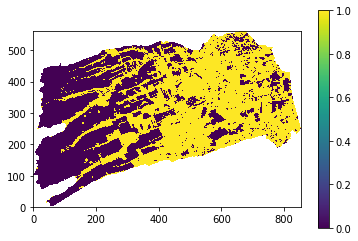

In [41]:
class_prediction[np.isnan(dist_blue_n)]= None
map_final = class_prediction.copy()*-1+2

plt.imshow(map_final, origin="lower")
plt.colorbar()

## 5. PRODES Data

PRODES provides the deforestation areas for the entire Cerrado biome, in the _shapefile_ format. In this case, the areas are acquired by visual interpretation, done by trained analysts, what guarantee a high level of accuracy. The idea is to use PRODES data to identify training areas, and then apply the algorithms to the savannas identification.

A simple visualization of the PRODES data can be seen below, as well as an approximation to the study area.

<img src="./Images/prodes.png" width="700">

The data is composed of a series of polygons, which represent the deforestation of the Cerrado until the end of 2018. This data was cropped to the study area using QGIS, and the result is shown in the code below. The code also gets the data projection, so it can be verified if all the data is compatible.

Text(0.5, 1, 'epsg:4674')

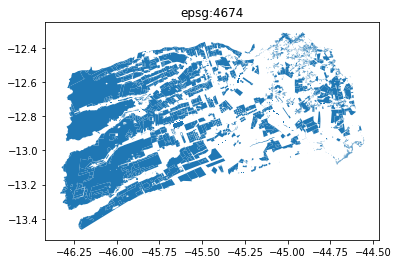

In [42]:
prodes = gp.read_file("./Data/Shape/prodes.shp", encoding="utf-8")

prodes.plot()
plt.title(str(prodes.crs['init']))

As the code showed, the projection of PRODES is 'epsg:4674', so it should be projected to 'epsg:4326' in order to make it compatible to the time series.

Text(0.5, 1, 'epsg:4326')

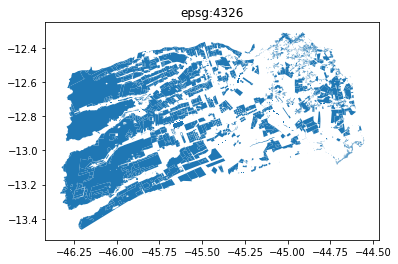

In [43]:
prodes = prodes.to_crs({'init': 'epsg:4326'})

prodes.plot()
plt.title(str(prodes.crs['init']))

An important thing to check is the attributes of the polygons. This can be done with the following command:

In [44]:
prodes.head()

,UID,ORIGIN_GID,PATHROW,VIEW_DATE,SOURCE,CLASSNAME,AREAMUNKM,COUNTY,UF,geometry
0,305721.0,1393597,220/69,2006-08-04,inpe cerrado,D_2006,0.039290,SÃO DESIDÉRIO,BA,POLYGON ((-45.85059122240693 -12.6904455168470...
1,306022.0,1393977,220/69,2006-08-04,inpe cerrado,D_2006,0.021477,SÃO DESIDÉRIO,BA,POLYGON ((-45.46654814158342 -12.4179271651065...
2,690466.0,1985583,220/69,2004-10-01,inpe cerrado,D_2004,1.698738,SÃO DESIDÉRIO,BA,POLYGON ((-45.7633578571793 -13.12846016830207...
3,853226.0,2241870,220/69,2002-09-02,inpe cerrado,D_2002,0.014715,SÃO DESIDÉRIO,BA,"POLYGON ((-45.2511093967812 -12.5249730392743,..."
4,853272.0,2241927,220/69,2002-09-02,inpe cerrado,D_2002,4.004511,AURORA DO TOCANTINS,TO,POLYGON ((-46.15229088629243 -12.5112800268714...


One of the attribute is `VIEW_DATE`, which represents the date of polygon's detection. If some polygon was detected after 2018-01-01, then it must be removed, since the map created is based on data only between 2017-01-01 and 2018-01-01. Polygons with `VIEW_DATE` before 2017-01-01 should not be excluded, since they represent the conversion from natural forest to other classes that happened in the past. This work aim to map the forest areas in the year of 2017, and not only changes in the year of 2017 should be considered.

In [45]:
prodes.sort_values("VIEW_DATE", ascending=False).head()

,UID,ORIGIN_GID,PATHROW,VIEW_DATE,SOURCE,CLASSNAME,AREAMUNKM,COUNTY,UF,geometry
4050,1375518.0,43094,220/69,2018-08-21,inpe cerrado,D_2018,0.021645,SÃO DESIDÉRIO,BA,POLYGON ((-45.49016695643985 -12.4739742918800...
4020,1374551.0,43004,220/69,2018-08-21,inpe cerrado,D_2018,0.017842,SÃO DESIDÉRIO,BA,POLYGON ((-45.11121715544732 -12.6783488043537...
4018,1374386.0,42989,220/69,2018-08-21,inpe cerrado,D_2018,0.015076,SÃO DESIDÉRIO,BA,"POLYGON ((-45.860313239964 -12.68626779901967,..."
4017,1374375.0,42988,220/69,2018-08-21,inpe cerrado,D_2018,0.062733,SÃO DESIDÉRIO,BA,POLYGON ((-45.06677652341779 -12.6869763119072...
4016,1374487.0,42999,220/69,2018-08-21,inpe cerrado,D_2018,0.035330,SÃO DESIDÉRIO,BA,POLYGON ((-45.84069018670272 -12.6704570879242...


This next lines of codes purge the polygons that were inserted after 2018-01-01 in the PRODES data, making it compatible with the results of this work.

In [46]:
prodes = prodes[prodes["VIEW_DATE"]<="2018-01-01"]
prodes.to_file("./Data/Shape/prodes_epsg4326.shp")
prodes.sort_values("VIEW_DATE", ascending=False).head()

,UID,ORIGIN_GID,PATHROW,VIEW_DATE,SOURCE,CLASSNAME,AREAMUNKM,COUNTY,UF,geometry
2154,528792.0,17334,220/69,2017-08-18,inpe cerrado,D_2017,0.093564,SÃO DESIDÉRIO,BA,POLYGON ((-44.94543611958119 -12.4506030513896...
2132,524690.0,17272,220/69,2017-08-18,inpe cerrado,D_2017,0.087201,SÃO DESIDÉRIO,BA,POLYGON ((-44.95222996973729 -12.7722200521136...
5252,521727.0,17225,220/69,2017-08-18,inpe cerrado,D_2017,0.040811,SÃO DESIDÉRIO,BA,POLYGON ((-46.11755127916814 -13.0920346091098...
2136,525815.0,17289,220/69,2017-08-18,inpe cerrado,D_2017,2.991866,SÃO DESIDÉRIO,BA,POLYGON ((-45.55727546918752 -12.6599362682441...
5251,521250.0,17218,220/69,2017-08-18,inpe cerrado,D_2017,7.178149,SÃO DESIDÉRIO,BA,POLYGON ((-45.47288277092309 -13.0493884357276...


The PRODES data is found in the vector format, while the time series are stored in a matrix/raster format. To compare them both, the vector data should be converted into a raster data, so that the comparison is viable. The final spatial resolution of the converted file should be the same as the time series maps, reducing it to approximately 250m.

The following code handles this transformations.

In [47]:
i, j = map_final.shape

warpCmd = 'gdal_rasterize -l prodes_epsg4326 -burn 1.0 -ts {0} {1} -a_nodata 0.0 -te {2} {3} {4} {5} -ot Float32 -of GTiff {6} {7}'.format(
                    j, i, long1, lat1, long2, lat2, './Data/Shape/prodes_epsg4326.shp', './Data/Reference/ref_prodes.tif')
subprocess.call(warpCmd, shell=True)

0

When converting the polygon to raster file, to all the pixels that did not contain a polygon has a value equal to zero. The analysis made here is concentrated to a specific study area, and the zero value also is used to the class named "Not-Forest", so, in this next step, the pixels outside the study area are substituted by a `NaN` value. By executing the following code, the pixels with a value equal to Zero (0, deep purple) correspond to the PRODES "Deforested" areas, and the pixels equal to One (1, yellow) correspond to the "Not-Deforested" areas.

1.0 0.0


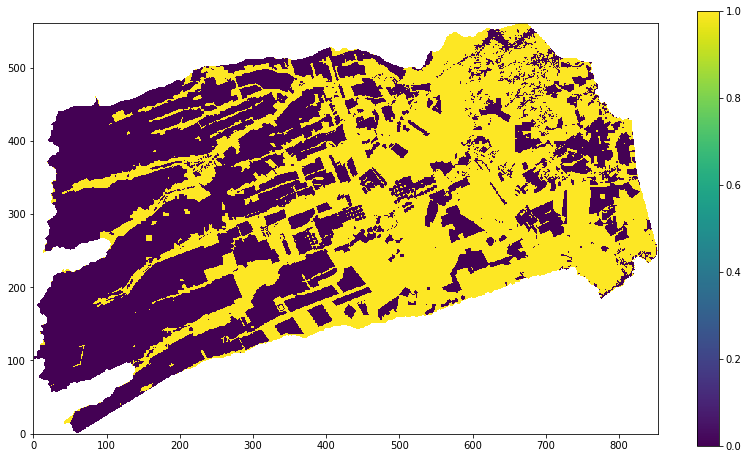

In [48]:
ref = np.flip(gdal.Open('./Data/Reference/ref_prodes.tif').ReadAsArray(), 0)*-1+1

for i in range(dist_blue.shape[0]):
    for j in range(dist_blue.shape[1]):
        if np.isnan(dist_blue[i,j]):
            ref[i,j] = None

fig = plt.figure(figsize=(14,8))
plt.imshow(ref, origin="lower")
plt.colorbar()
print(np.nanmax(ref), np.nanmin(ref))

## 6. Comparison

The classification made with the DTW method can be compared to the PRODES data. By doing so, the classification's accuracy can be accessed and furthermore compared to other classification methods. Since reference map and classification map are both in the raster file format, and their classes follow the same labeling format, the can be easily visually compared by a simple subtraction task. Indexes such as Cohen's Kappa and Total Accuracy can be easily calculated.

The following code shows the differences between classification and reference, as well as the confusion matrix and indexes.

The numbers in the map have the following meaning:

+ -1 (dark blue)
    + Deforested area classified as not deforested.
+ 0 (teal)
    + Correctly classified area.
+ 1 (yellow)
    + Not deforested area classified as deforested.

Confusion matrix:
 [[126893  25112]
 [  8063 128889]] 

Global Accuracy: 0.8852
Kappa: 0.7712


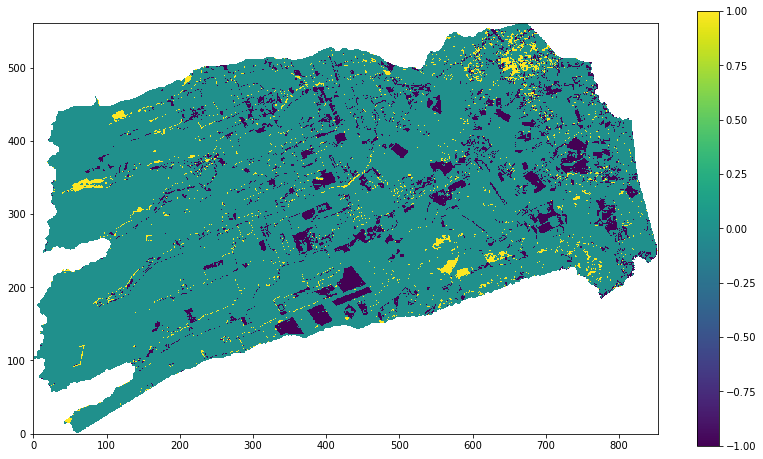

In [49]:
fig = plt.figure(figsize=(14,8))
map_diff = ref-map_final
plt.imshow(map_diff, origin="lower")
plt.colorbar()

list_ref = []
list_map = []

for i in range(map_diff.shape[0]):
    for j in range(map_diff.shape[1]):
        if not np.isnan(map_diff[i,j]):
            list_ref.append(ref[i,j])
            list_map.append(map_final[i,j])

conf_matr = cm(list_ref, list_map)

print("Confusion matrix:\n", conf_matr, "\n")
print("Global Accuracy: %.4f" % ((conf_matr[0,0]+conf_matr[1,1])/np.sum(conf_matr.ravel())))

k = kappa(list_ref, list_map)
print("Kappa: %.4f" % (k))

In the end, the classification can be stored in the computer's hard memory, so that it can be accessed by GIS applications, like QGIS, TerraView or ARCGIS.

In [50]:
ref2 = gdal.Open('./Data/Reference/ref_prodes.tif')
in_band = ref2.GetRasterBand(1)

gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create('classification_result.tif', in_band.XSize, in_band.YSize, 1, in_band.DataType)
out_ds.SetProjection(ref2.GetProjection())
out_ds.SetGeoTransform(ref2.GetGeoTransform())

out_ds.GetRasterBand(1).WriteArray(np.flip(map_final, 0))

del out_ds

## 7. Conclusion

This methodology can be used to achieve a classification of the land cover/land use of the study area, regarding two classes: Deforested area and Not-Deforested area. The accuracy expected is not high, in comparison with the product of PRODES, since the PRODES data is made by human analysts by visual interpretation.

It can be noticed, that a large number of deforested area was classified incorrectly as not deforested. This is noticed by looking at the map or by analysing the a12 term of the confusion matrix, which is 25,112. This number is the total amount of pixels that were classified incorrectly as "not deforested". This result can be explained by the PRODES' nature. This data has the deforesting area always increased, which means, deforested areas that were recovered are not removed from the database. So, this large area could mean that these are restored forest areas.

Another theory for this large area incorrectly classified as "not deforested", is that the similarities between the spectral behavior of the suppressed vegetation is very similar to the vegetation that came after it. The MODIS data used in this project has only 4 different bands of reflectance, and if this values are similar to the new vegetation not only in space but also in time, the algorithm could be fooled. The deforesting would be detected by PRODES when it happened, but the algorithm would interpret it as only a deviation in the time series, without a meaning.

In conclusion, this methods could simulate the PRODES data with an accuracy rate of 88.52%. With this accuracy, it could not be used to substitute the PRODES data, but it can be a nice fast approach for the problem, regarding the accuracy.

Behind all the methods here described lies the intention to automatize the PRODES process. High quality results, comparable with the PRODES product are not possible to achieve with such a simple work flow, but it can be the fist step in the right direction of the algorithms to be used in the creation of the PRODES product in the future.